<br>
<u>Notebook Five</u> | 
<a href=https://github.com/andrealeone/NLP target=_blank>Repository</a>
<br><br>
<b>Semantic Networks</b><br><br>
Andrea Leone<br>
University of Trento<br>
February 2022
<br><br>

In [1]:
import project 

import os
import spacy
import numpy             as np
import pandas            as pd
import networkx          as nx
import matplotlib.pyplot as plt
import collections
import pickle
import grave

from tqdm.notebook import tqdm

In [2]:
records = project.sql_query(""" 
    SELECT * FROM talks
    WHERE transcript IS NOT NULL
    ORDER BY slug ASC;
""")

df = project.create_dataframe_from(records) 

<br>Load the pipeline

In [3]:
nlp = spacy.load("en_core_web_lg") 

<br>Process all transcripts

In [4]:
docs_pkl = "data/docs.v4.pkl" 

if not os.path.exists( docs_pkl ): 

    docs = list() 

    for _,record in tqdm( list(df.iterrows()) ):
        docs.append( nlp( record["transcript"] ) )

    with open( docs_pkl, "wb" ) as file: 
        pickle.dump(docs, file)

else: 

    with open( docs_pkl, "rb" ) as file: 
        docs = pickle.load(file)

<br>

<b>Semantic distribution</b>

<br>Let's start with the token "creativity"

In [5]:
tag = nlp("creativity")[0] 

In [6]:
dt1 = [(i, row) for i,row in df.iterrows() if tag.text in row["tags"]] 

<br>Distribution of the tagged talks in the years

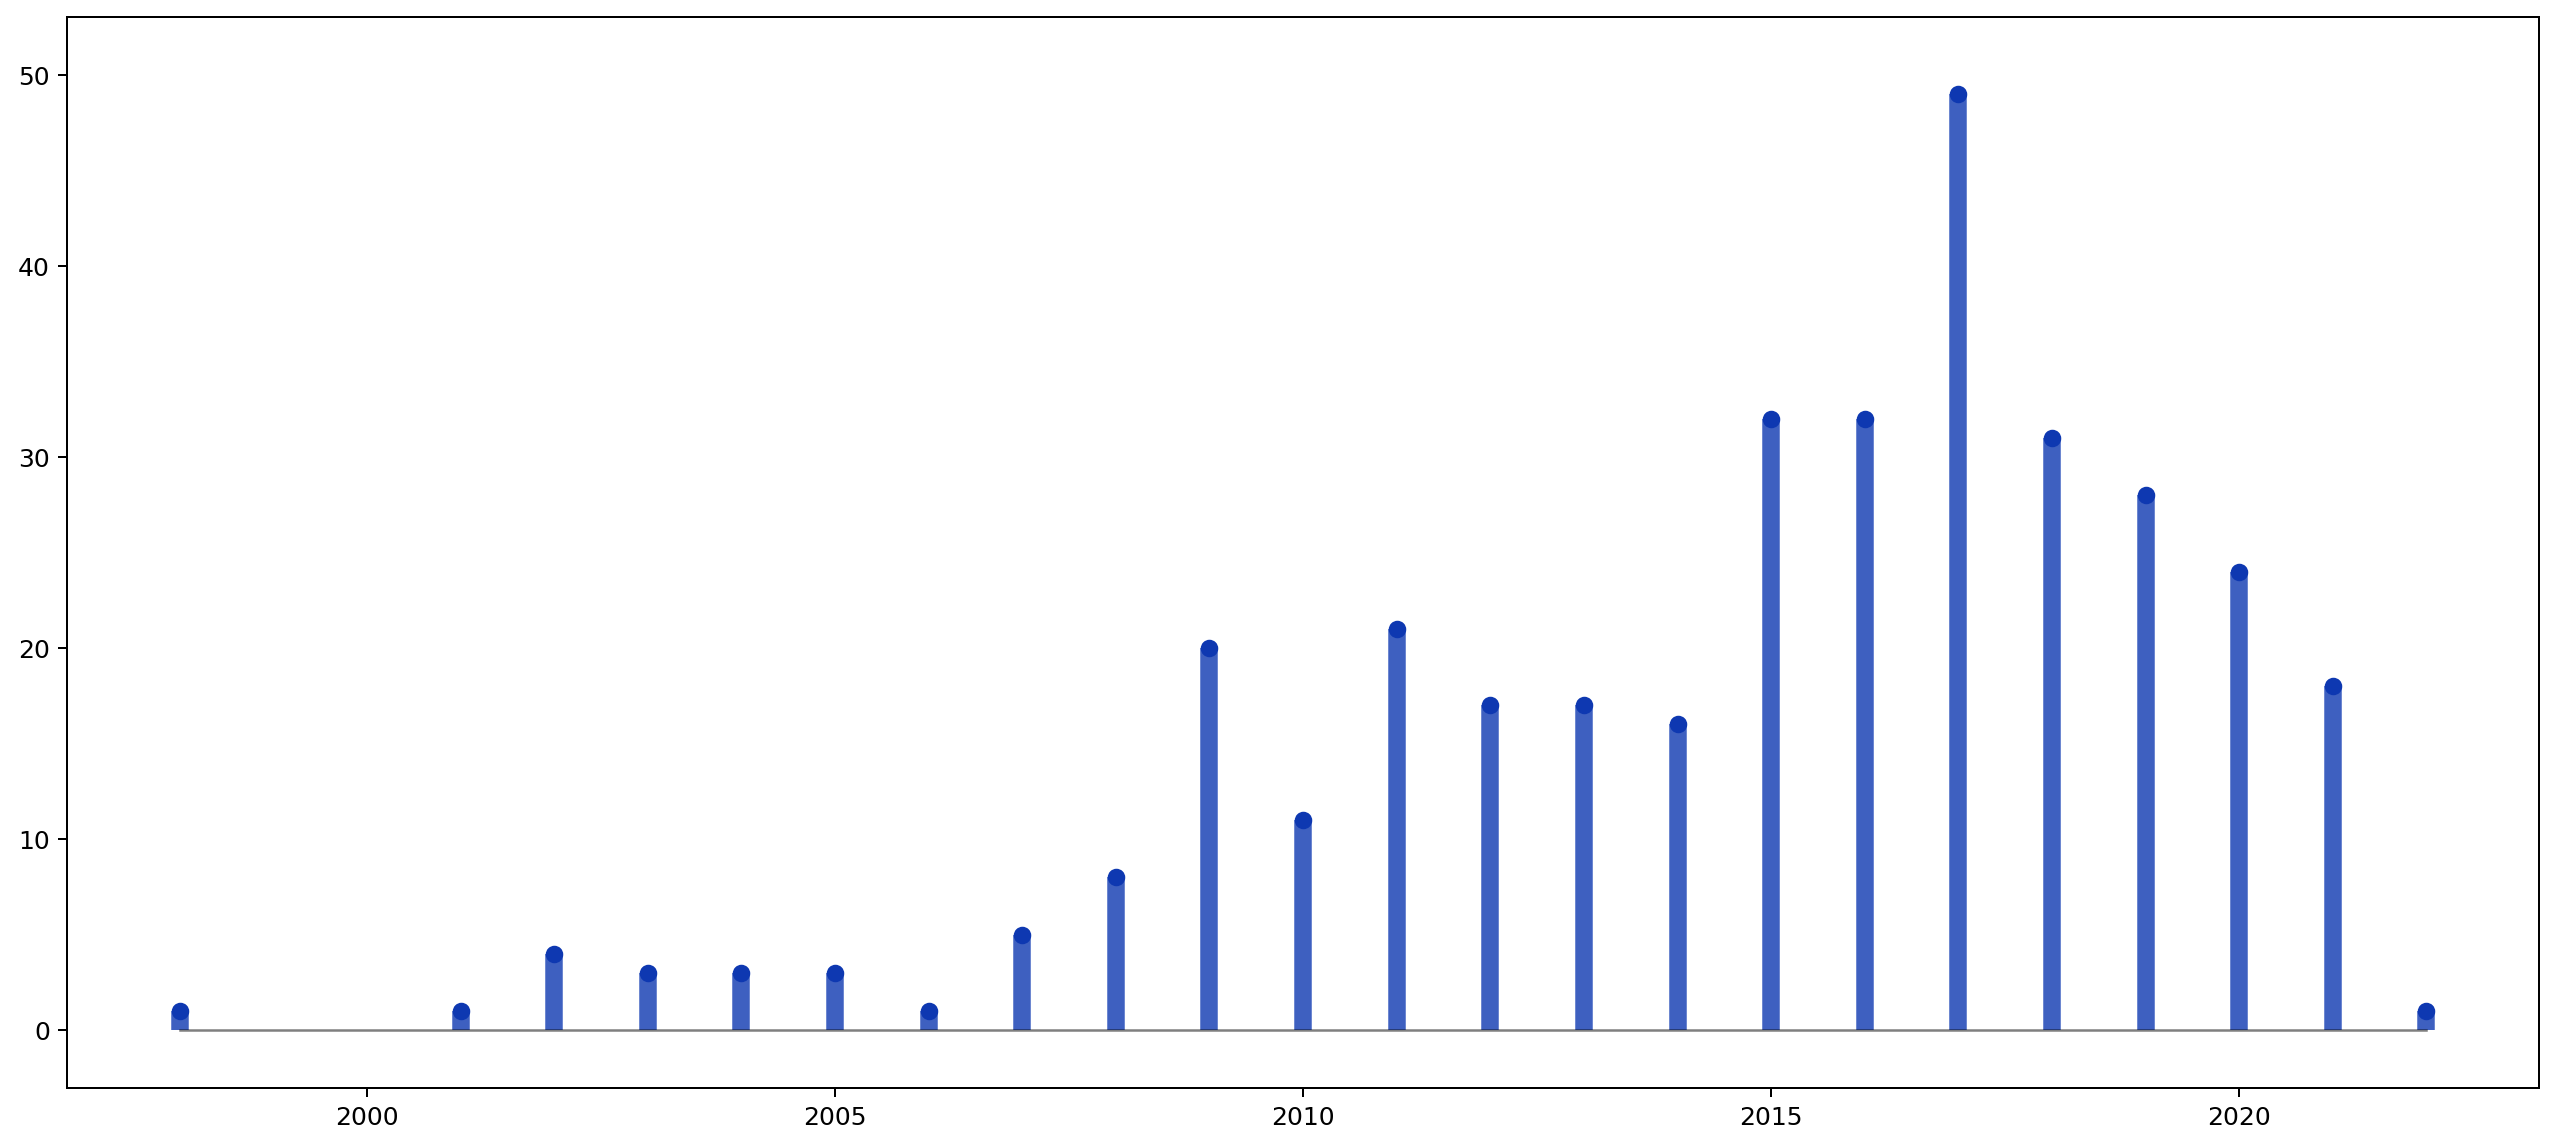

In [7]:
years, counts = project.unzip_array( 
    collections.Counter([row["year"] for _,row in dt1]).items()
) 

plt.figure( figsize=(45/2.54, 20/2.54), dpi=180 )

markerline, stemlines, baseline = plt.stem(years, counts)

plt.setp(baseline,   linewidth=1, alpha=.5, color="black")
plt.setp(stemlines,  linewidth=7, alpha=.8, color="#0E38B1")
plt.setp(markerline, linewidth=0, alpha=1,  color="#0E38B1", marker="o")

plt.ylim(-3, 53)
plt.show()

<br><br>

<br>Define the dataset, split for the two decades: 2002-2012 and 2012-2022

In [8]:
ds1 = { 
    "02-12": [ (i,row) for i,row in dt1 if 2002 < row["year"] < 2013 ],
    "12-22": [ (i,row) for i,row in dt1 if 2012 < row["year"] < 2023 ]
}

In [9]:
print( len(ds1["02-12"]), len(ds1["12-22"]) )

92 248


<br>Define the logic to analyse the texts in the dataset: get the lemmas and collect the similarity score with the focused tag

In [10]:
def analyze(tag, rows, task="docs", pos="NOUN", to_df=False, norm_c=False, split_value=0.5): 

    if task == "docs":

        lemmas       = list()
        similarities = dict()
        empty_array  = np.zeros(300)

        for (i, row)  in rows:
            for token in docs[i]:
                if token.pos_ == pos:
                    if not np.array_equal(token.vector, empty_array):

                        lemmas.append(token.lemma_)
                        similarities[ token.lemma_ ] = tag.similarity(token)

        lemmas = collections.Counter(lemmas).most_common()
        lemmas = [
            [ lemma, similarities[lemma], count ] for lemma, count in lemmas
        ]

        split_value = int( len(lemmas) * split_value )

        results = sorted(
            lemmas[:split_value], key = lambda x: x[1], reverse=True
        )

        cs = ["word", "tag-similarity", "word-count"]
        sm = sum([c for _,_,c in results])
        
        if norm_c:
            cs.append("norm-wc")
            results = [ [l,s,c,(c/sm)*1000] for l,s,c in results]

        if to_df:
            return pd.DataFrame(results, columns=cs)
        else:
            return results

    if task == "tags":

        tags = list()

        for (i, row) in rows:
            for tag  in row["tags"]:
                tags.append(tag)

        results = collections.Counter(tags).most_common()

        if to_df:
            return pd.DataFrame(results, columns=["tag", "tag-count"])
        else:
            return results

def sort_values(rows, st=0.5): 

    lst = [ row for row in sorted(rows, key=lambda x : x[2]) if row[1] > st ]
    return sorted(lst, key=lambda x : x[1], reverse=True)

<br>The analysis extracts a particular part-of-speech role; in this case, all nouns (suggested alternative: verbs)

In [11]:
ds1.keys()

dict_keys(['02-12', '12-22'])

In [12]:
dr1 = dict() 

for key in ds1.keys(): 
    dr1[key] = analyze(tag, ds1[key], pos="NOUN", to_df=True, norm_c=True).iloc[:30]

    print( "\ndecade 20{}".format(key) )
    print( dr1[key].iloc[:15] )


decade 2002-12
               word  tag-similarity  word-count   norm-wc
0        creativity        1.000000          71  2.165426
1       imagination        0.759219          24  0.731975
2       inspiration        0.702141          19  0.579480
3        innovation        0.664305          28  0.853971
4           passion        0.655068          22  0.670977
5        motivation        0.619925           9  0.274491
6      storytelling        0.590511          23  0.701476
7         curiosity        0.589669           6  0.182994
8            talent        0.589180          17  0.518482
9        brilliance        0.585092           2  0.060998
10            sense        0.582550          71  2.165426
11           genius        0.581985          25  0.762474
12  experimentation        0.570823           6  0.182994
13      possibility        0.566758          21  0.640478
14         openness        0.561217           2  0.060998

decade 2012-22
             word  tag-similarity  word-

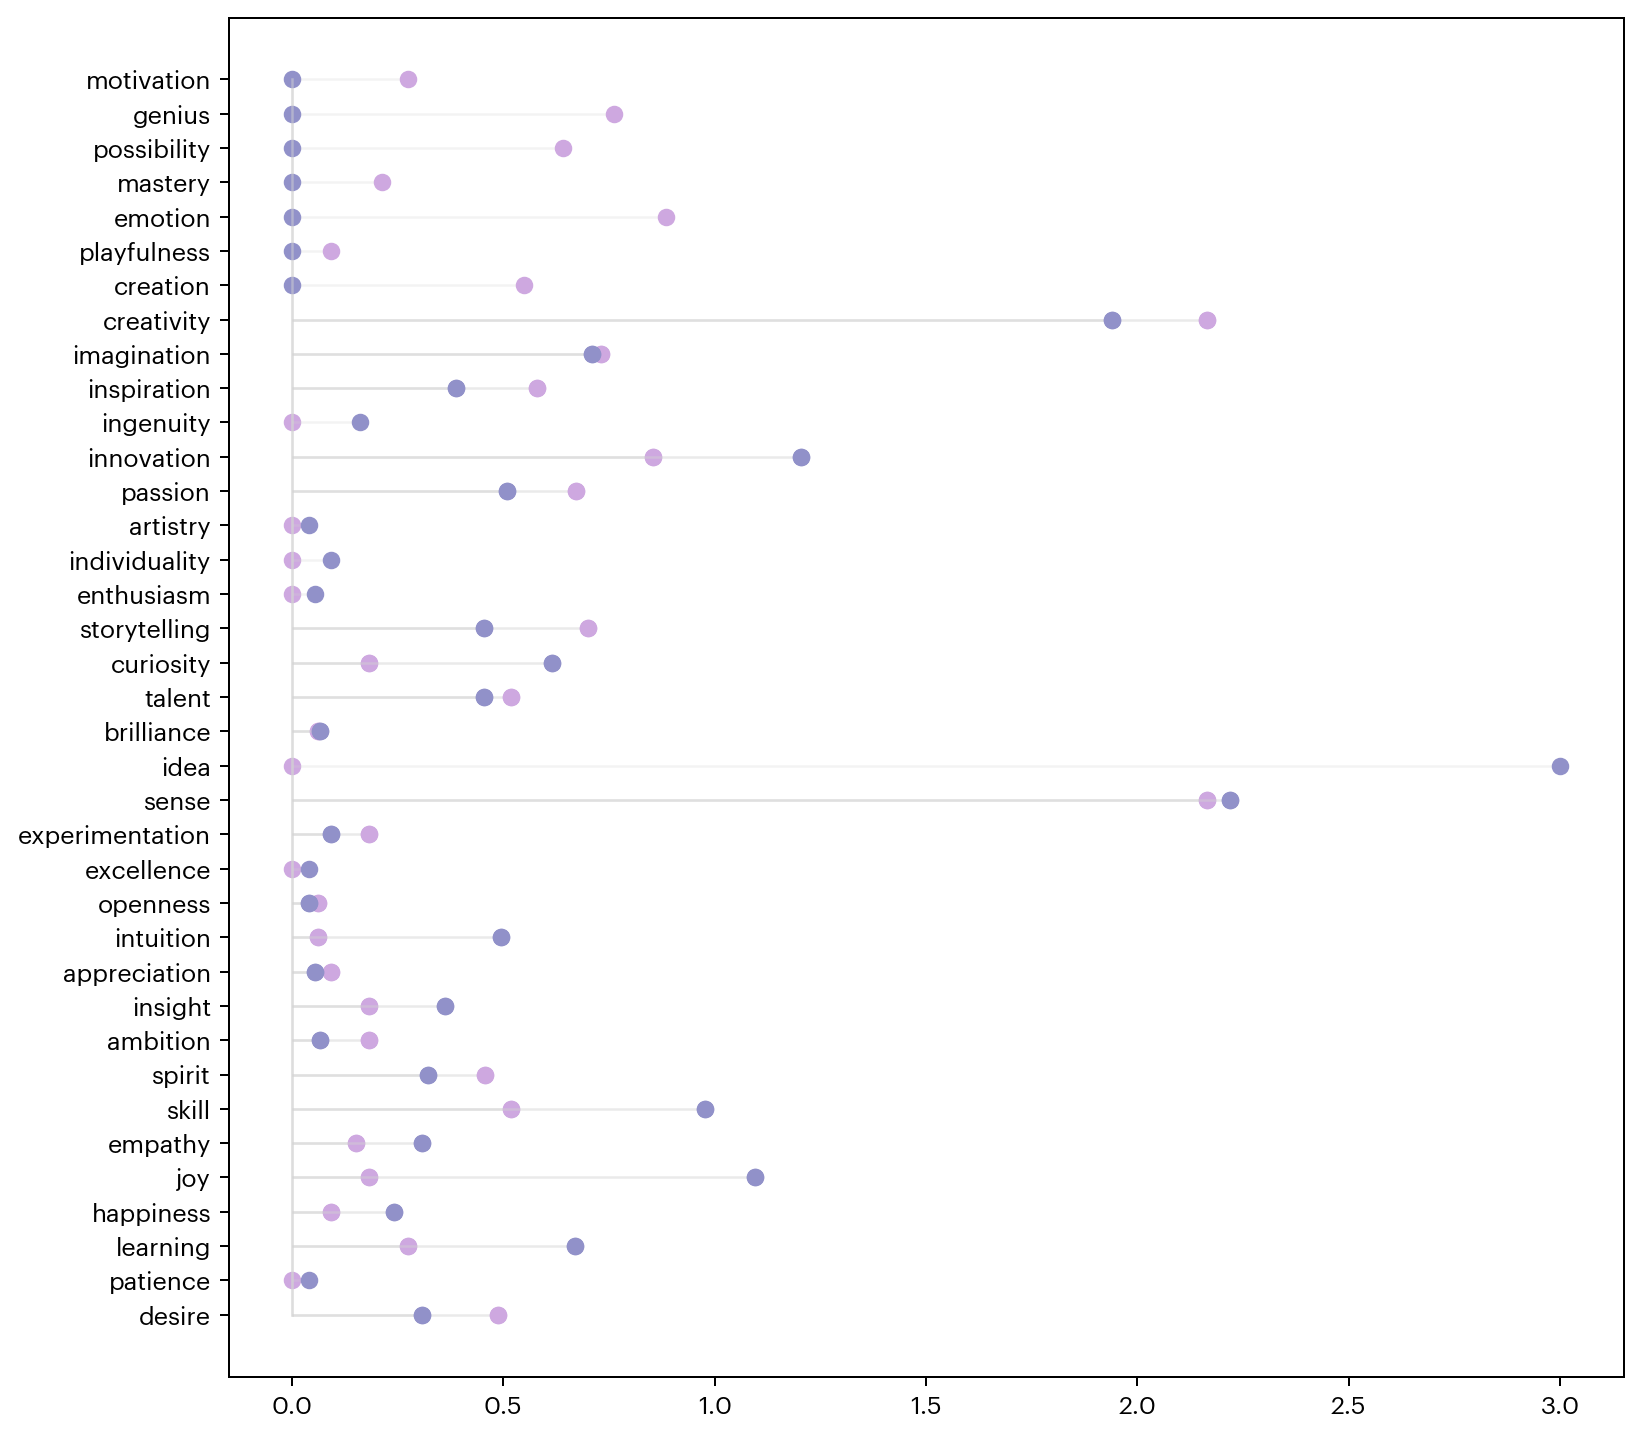

In [13]:
wls = list() 

for dr in dr1.values():
    wls.extend([row["word"] for i,row in dr.iterrows()])

wls.reverse()

def plot_stem_difference(dr, wls, cs, mv=100):

    plt.rcParams['font.family'] = 'Graphik'
    fig, ax = plt.subplots( figsize=(10,10), dpi=180 )

    for key in dr.keys():
        wll = list()

        for wl in wls:
            nwc = dr1[key][ dr1[key]["word"] == wl ]["norm-wc"]

            if len(nwc) > 0:
                val = nwc.iloc[0]
                wll.append( val if val < mv else mv )
            else:
                wll.append( 0 )

        wld = dict( zip(wls, wll) )
        wld = dict( sorted( wld.items(), key=lambda x:x[1] ) )

        markerline, stemlines, baseline = plt.stem(wls, wll, markerfmt=cs[key], orientation="horizontal")

        plt.setp(baseline,   linewidth=1, alpha=.5,  color="lightgray")
        plt.setp(stemlines,  linewidth=1, alpha=.25, color="lightgray")
        plt.setp(markerline, linewidth=0, alpha=1,   color=cs[key], marker="o")

    plt.show()

plot_stem_difference(dr1, wls, cs={ "02-12": "#CEA8E0", "12-22": "#9191C9" }, mv=3)

<br>Use the sorted results of the analysis to create a graph for each decade

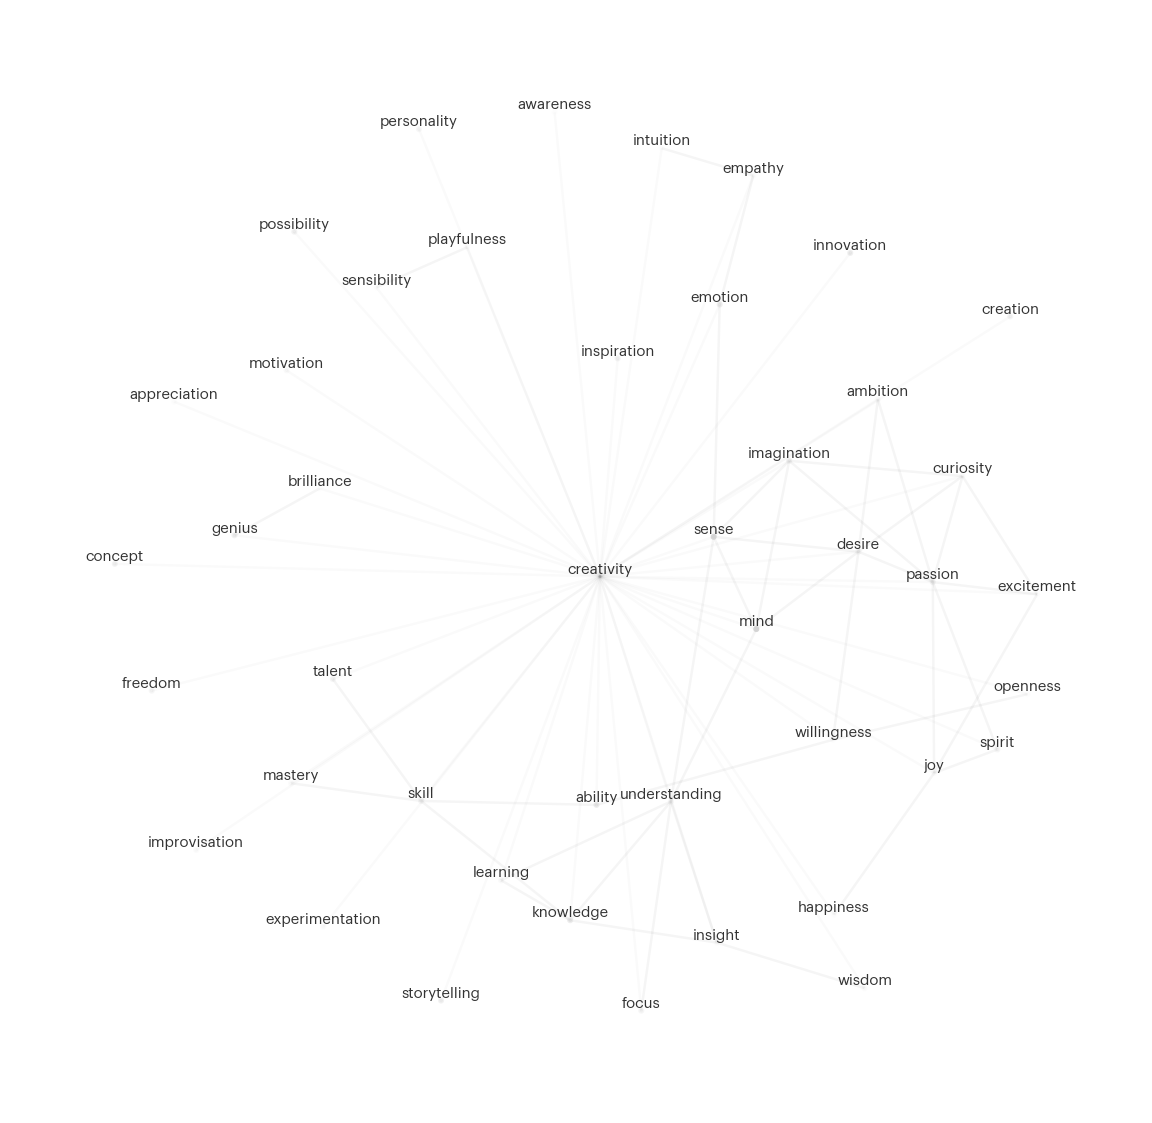

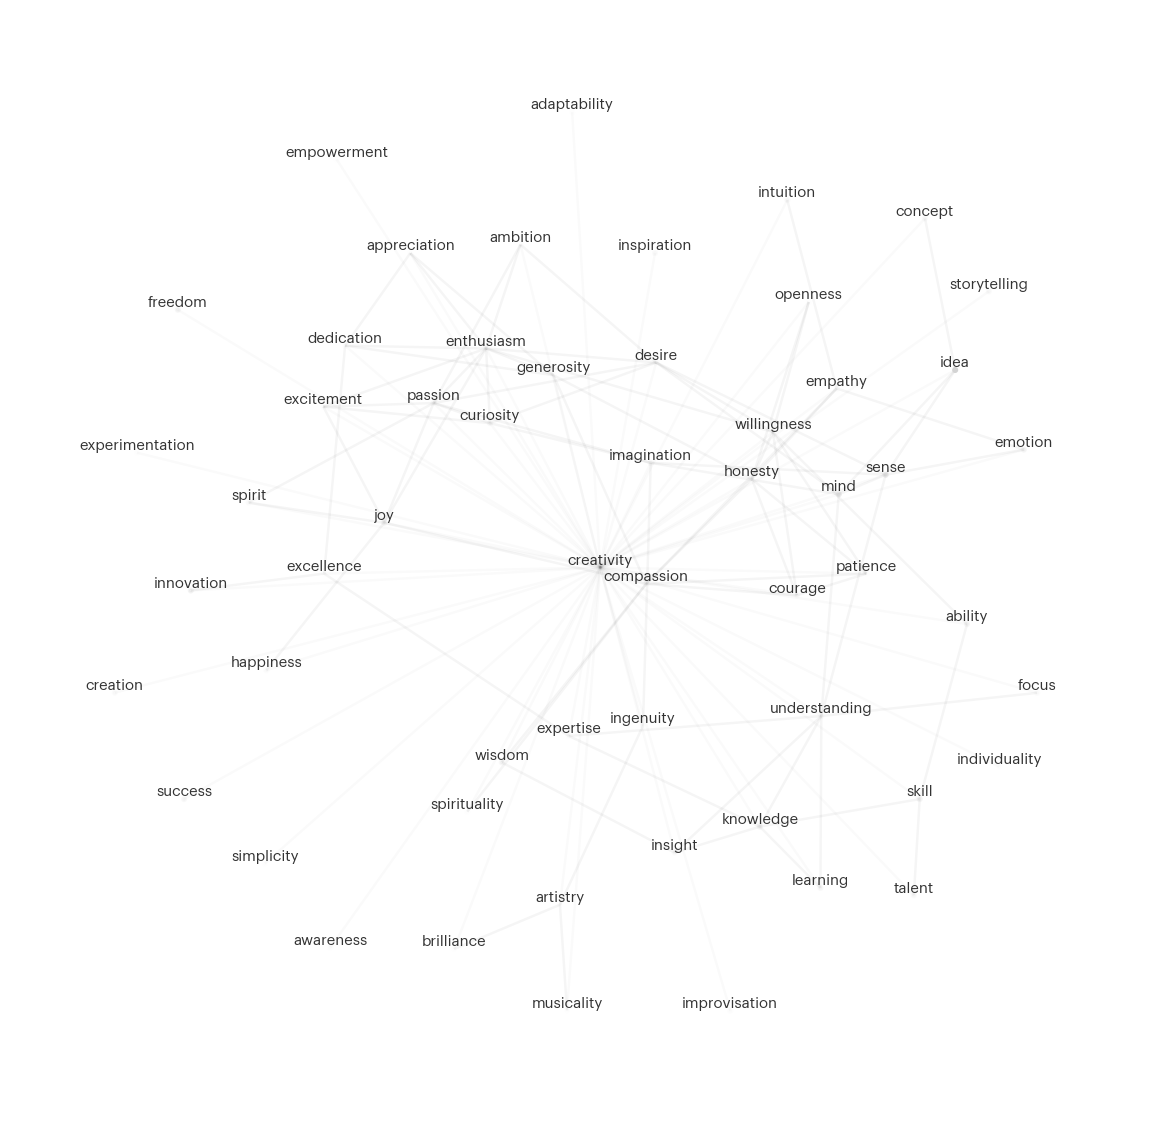

In [14]:
G = dict(); gvs = dict([ 
    [key, sort_values( analyze(tag, ds1[key], pos="NOUN", norm_c=True), st=0.5 )] for key in ds1.keys()
])

for key in ds1.keys(): 

    G[key] = nx.Graph() 
    G[key].add_weighted_edges_from([
        (tag.text, lemma, w) for lemma,w,_,_ in gvs[key][1:]
    ]); ns = list()

    for lemma, s,c,n in gvs[key] : G[key].add_node(lemma, similarity=s, count=c); ns.append(n)

    ns = np.array(ns); ns = (ns/np.linalg.norm(ns) * 2); np.putmask(ns, ns > 1, 1); ns[0] = 0
        
    lemmas = [ nlp(lemma)[0] for lemma,_,_,_ in gvs[key] ]

    for l1 in lemmas:
        for l2 in lemmas:

            w = l2.similarity(l1)
            if 0.62 < w < 1 : G[key].add_edge(l1.text, l2.text, weight=w)

    fig, ax = plt.subplots( figsize=(8,8), dpi=180 )

    pos = nx.spring_layout(G[key], seed=5)
    iet = len(G[key].edges()) - len(gvs[key])

    nx.draw(G[key], pos, **{
        "node_size": 0, "edge_color": (0,0,0,.02),
        "edgelist": list(G[key].edges())[:len(gvs[key])-1]
    })

    nx.draw_networkx_nodes(G[key], pos, **{
        "node_size": 2, "node_color": "lightgray",
        "node_shape": "o", "alpha": ns,
        "nodelist": list(G[key].nodes())
    })

    nx.draw_networkx_edges(G[key], pos, **{
        "edge_color": ( 0,0,0, .04),
        "edgelist": list(G[key].edges())[-iet:]
    })

    nx.draw_networkx_labels(G[key], pos, **{
        "font_color": "black", "font_size": 6,
        "font_family": "Graphik", "alpha": .8,
        "horizontalalignment": "center",
        "verticalalignment": "bottom"
    })

    fig.savefig("images/network.{}.{}.svg".format(tag.text, key), format="svg", dpi=1200)
    plt.show()

<br><b>Semantic tag distribution</b>

<br>Aggregate the relationship among tags

In [15]:
wts = dict(); gvs = dict(); nvs = dict() 

for key in ds1.keys():

    wts[key] = list()
    for _,row in ds1[key]:
        wts[key].extend(row["tags"])
    
    cln = dict( collections.Counter(wts[key]).most_common() )

    nws = np.array(list(cln.values()))
    nws = nws/np.linalg.norm(nws); nws[0] = 0
    
    nvs[key] = dict( zip( cln.keys(), nws ) )
    gvs[key] = list()

    for word in set(wts[key]):

        if word != tag.text:
            m = nlp(word)[0]

            if not np.array_equal(m.vector, np.zeros(300)):
                w = tag.similarity( m )

                if w > 0.425:
                    gvs[key].append([ tag.text, word, w ])

<br>Like before, create a graph from the results for both decades

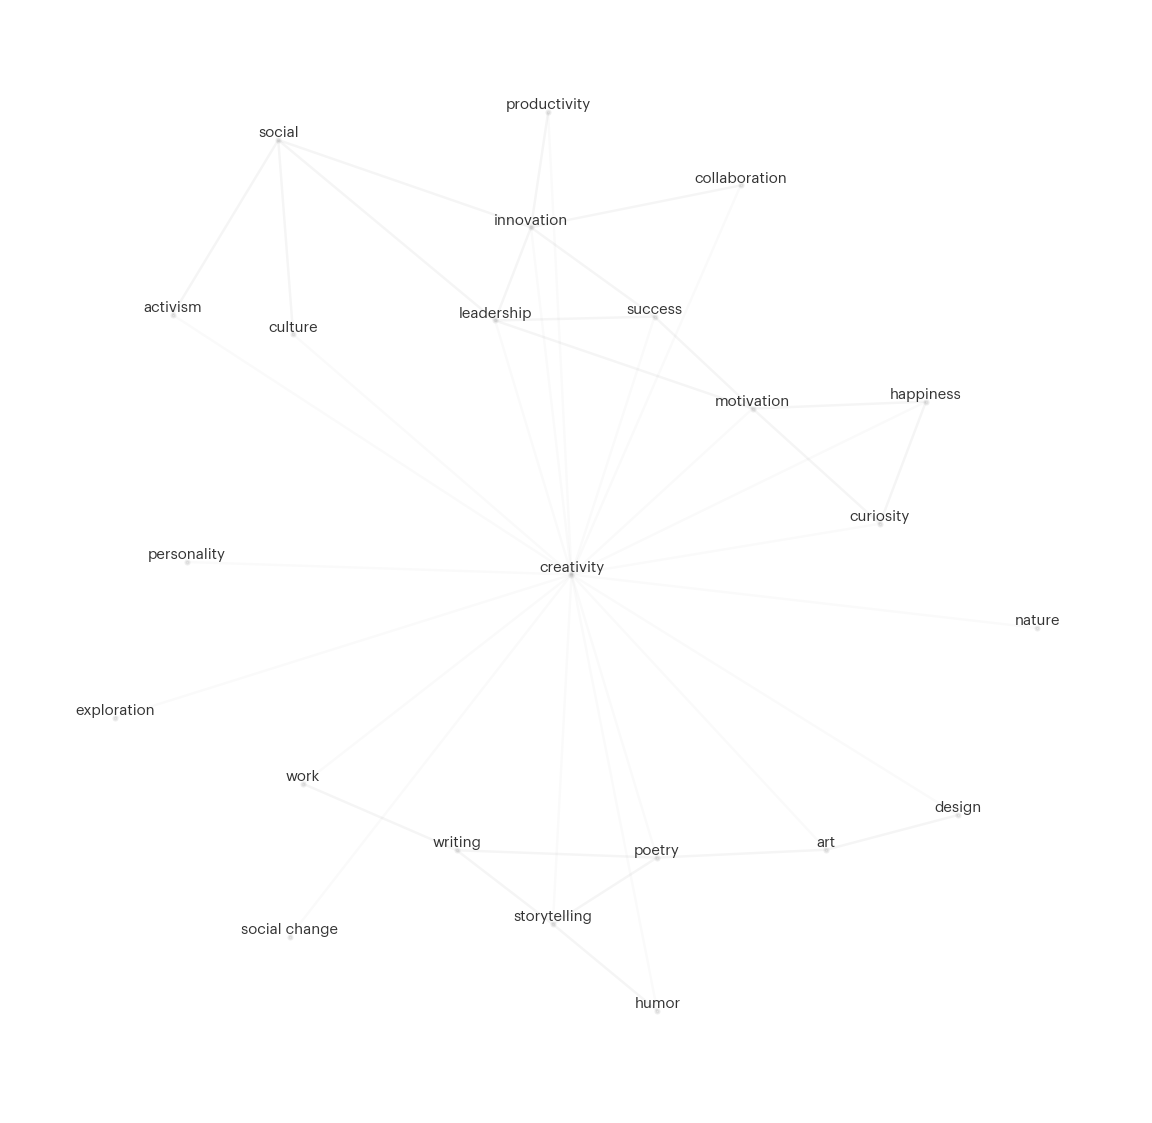

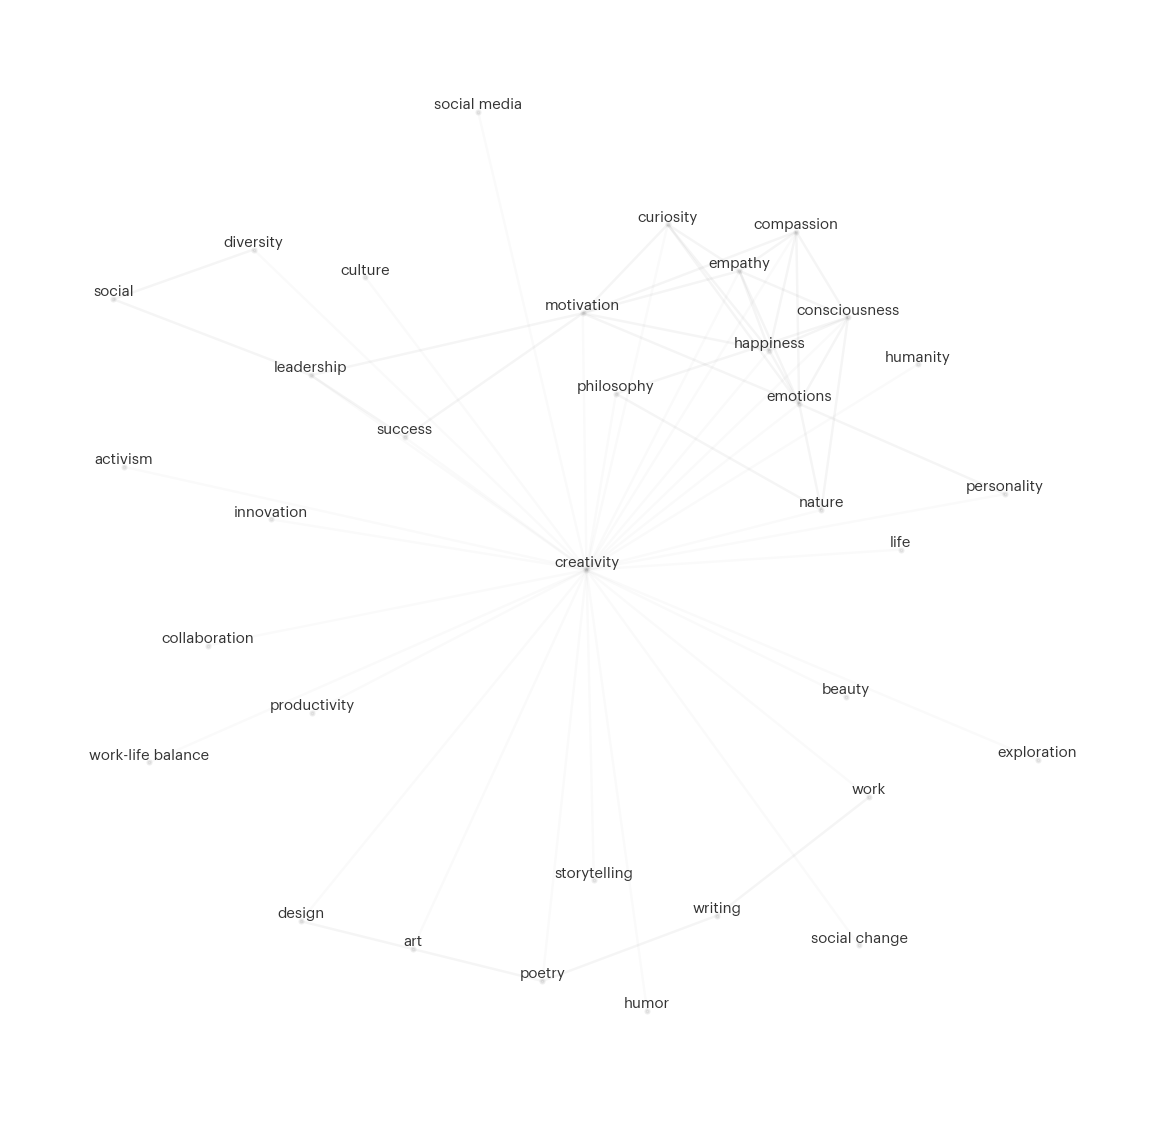

In [16]:
G = dict() 

for key in ds1.keys(): 

    G[key] = nx.Graph() 
    G[key].add_weighted_edges_from([
        (tag.text, word, w) for _,word,w in gvs[key]
    ])

    lemmas = [ nlp(lemma)[0] for _,lemma,_ in gvs[key] ]

    for l1 in lemmas:
        for l2 in lemmas:
            if l1.text != l2.text:

                w = l2.similarity(l1)
                if 0.5 < w < 1 : G[key].add_edge(l1.text, l2.text, weight=w)

    fig, ax = plt.subplots( figsize=(8,8), dpi=180 )
    pos = nx.spring_layout(G[key], seed=5)


    nx.draw(G[key], pos, **{
        "node_size": 0, "edge_color": (0,0,0,.02),
        "edgelist": list(G[key].edges())[:len(gvs[key])-1]
    })

    nx.draw_networkx_nodes(G[key], pos, **{
        "node_size": 2, "node_color": "darkgray",
        "node_shape": "o", "alpha": .2,
        "nodelist": list(G[key].nodes())
    })

    nx.draw_networkx_edges(G[key], pos, **{
        "edge_color": ( 0,0,0, .04),
        "edgelist": list(G[key].edges())[-len(gvs[key]):]
    })

    nx.draw_networkx_labels(G[key], pos, **{
        "font_color": "black", "font_size": 6,
        "font_family": "Graphik", "alpha": .8,
        "horizontalalignment": "center",
        "verticalalignment": "bottom"
    })

    plt.show()

<br>Plot the zipfian word count distribution

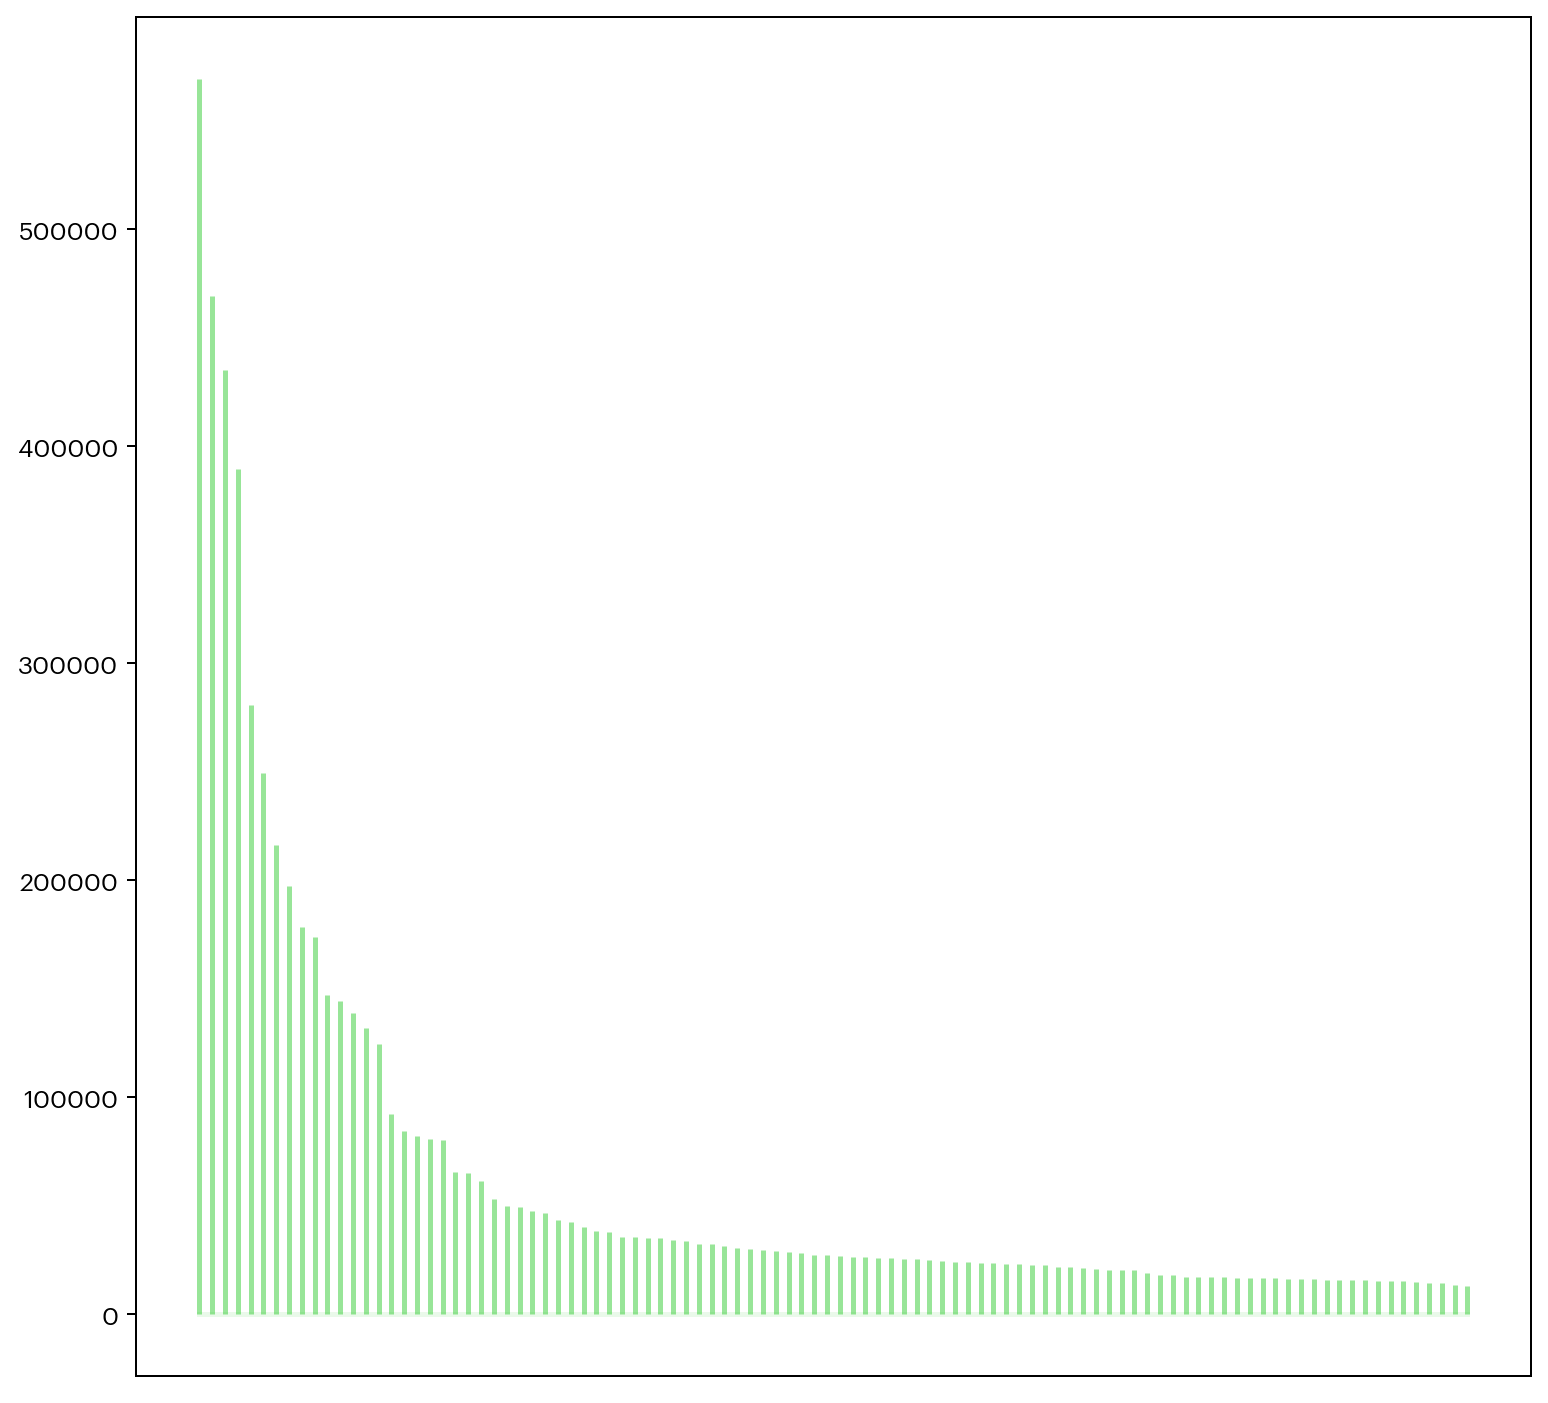

In [17]:
word_counts = collections.Counter() 

for doc in docs: word_counts.update(
    collections.Counter([
        token.lemma_ for token in doc
    ])
)
    
X, Y = project.unzip_array( word_counts.most_common() ) 

fig, ax = plt.subplots( figsize=(10,10), dpi=180 ) 

markerline, stemlines, baseline = plt.stem(X[:100], Y[:100])

plt.setp(stemlines,  linewidth=2, alpha=.5, color="limegreen")
plt.setp(baseline,   linewidth=2, alpha=.1, color="limegreen")
plt.setp(markerline, linewidth=0, alpha=1,  color="limegreen", marker="o", markersize=0)

plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

<br/>